# What sells a car?

Hundreds of free advertisements for vehicles are published on the Crankshaft List site every day.

We are performing an exploratory analysis on data of car sales in order to understand the influence of various parameters such as *age*, *color*, *transmission* and *mileage* of a car. We will:

1. Deal with missing, duplicate and erroneous data.
2. Deal with outliers in order to ensure our analysis is generalized and not affected by them.
3. Look at summary plots such as histograms and boxplots to understand the distribution of values.
4. Understand correlations and find the factors that primarily affect price of a vehicle.

## Initialization

In [1]:
# Loading all the libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#Numpy helps deploy NaN values
import numpy as np

### Load data

In [2]:
# Load the data file into a DataFrame
try:
    vehicles = pd.read_csv('/datasets/vehicles_us.csv')
    vehicles.head()
except:
    print('Error loading data. Please check filepath or file type')

### Explore initial data

The dataset contains the following fields:
- `price`
- `model_year`
- `model`
- `condition`
- `cylinders`
- `fuel` — gas, diesel, etc.
- `odometer` — the vehicle's mileage when the ad was published
- `transmission`
- `paint_color`
- `is_4wd` — whether the vehicle has 4-wheel drive (Boolean type)
- `date_posted` — the date the ad was published
- `days_listed` — from publication to removal

In [3]:
# print the general/summary information about the DataFrame
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51525 entries, 0 to 51524
Data columns (total 13 columns):
price           51525 non-null int64
model_year      47906 non-null float64
model           51525 non-null object
condition       51525 non-null object
cylinders       46265 non-null float64
fuel            51525 non-null object
odometer        43633 non-null float64
transmission    51525 non-null object
type            51525 non-null object
paint_color     42258 non-null object
is_4wd          25572 non-null float64
date_posted     51525 non-null object
days_listed     51525 non-null int64
dtypes: float64(4), int64(2), object(7)
memory usage: 5.1+ MB


In [4]:
# print a sample of data
vehicles.head()

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed
0,9400,2011.0,bmw x5,good,6.0,gas,145000.0,automatic,SUV,NaN,1.0,2018-06-23,19
1,25500,NaN,ford f-150,good,6.0,gas,88705.0,automatic,pickup,white,1.0,2018-10-19,50
2,5500,2013.0,hyundai sonata,like new,4.0,gas,110000.0,automatic,sedan,red,NaN,2019-02-07,79
3,1500,2003.0,ford f-150,fair,8.0,gas,NaN,automatic,pickup,NaN,NaN,2019-03-22,9
4,14900,2017.0,chrysler 200,excellent,4.0,gas,80903.0,automatic,sedan,black,NaN,2019-04-02,28


**General Observations about the data**

Missing values exist in the `model_year`, `cylinders`, `odometer` and `paint_color` columns. `odometer` and `model_year` are of obvious concern since they are likely to affect price. We will explore the option to fill these values or discard missing values. 

The `is_4wd` column seems to be a boolean column. We can fill the na values with 0 or False.

The `date_posted` and `model_year` column can be converted to datetime. 

**Next Steps:**
1. Explore columns with missing values to determine how they can be filled or if they need to be dropped.
2. Correct Data Types
3. Remove any duplicates

## Treat missing values

In [5]:
missing_year = vehicles['model_year'].isna().sum() / vehicles.shape[0] * 100

print(f'Percentage of values missing Model Year: {missing_year:.2f}%')

Percentage of values missing Model Year: 7.02%


In [6]:
vehicles.isna().sum()*100/len(vehicles)

pd.DataFrame(round((vehicles.isna().mean()*100),2)).style.background_gradient('coolwarm')

vehicles.isna().mean() * 100

price            0.000000
model_year       7.023775
model            0.000000
condition        0.000000
cylinders       10.208637
fuel             0.000000
odometer        15.316836
transmission     0.000000
type             0.000000
paint_color     17.985444
is_4wd          50.369723
date_posted      0.000000
days_listed      0.000000
dtype: float64

In [7]:
vehicles.corr()

,price,model_year,cylinders,odometer,is_4wd,days_listed
price,1.000000,0.428656,0.296627,-0.420299,NaN,-0.000682
model_year,0.428656,1.000000,-0.148040,-0.473948,NaN,-0.005703
cylinders,0.296627,-0.148040,1.000000,0.090160,NaN,0.005517
odometer,-0.420299,-0.473948,0.090160,1.000000,NaN,0.003804
is_4wd,NaN,NaN,NaN,NaN,NaN,NaN
days_listed,-0.000682,-0.005703,0.005517,0.003804,NaN,1.000000


In [8]:
missing_odometer = vehicles['odometer'].isna().sum() / vehicles.shape[0] * 100
print(f'Percentage of values missing Odometer: {missing_odometer:.2f}%')

Percentage of values missing Odometer: 15.32%


1. It's quite difficult to predict `model_year` using any other variable. We have little choice but to drop the missing values, leaving us with approximately 93% of the data. 
2. We see a strong linear correlation between `odomoeter` and `model_year`. We can use the `model_year` and `type` columns to help us fill in the missing odometer values.

In [9]:
vehicles = vehicles.query('~model_year.isna()')
vehicles['model_year'].isna().sum()

0

Let's check how this affected the missing odometer values

In [10]:
missing_odometer_new = vehicles['odometer'].isna().sum() / vehicles.shape[0] * 100
print(f'Percentage of values missing Odometer: {missing_odometer_new:.2f}%')

Percentage of values missing Odometer: 15.33%


Practically the same. We will now fill these missing values with medians(to comepnsate for potential outliers) of values from `model_year` as well as `type` as the usage of a car depends on the type 

In [11]:
vehicles['type'] = vehicles['type'].str.lower()

In [12]:
fill_table = vehicles.groupby(['model_year','type'])['odometer'].median()
fill_table

model_year  type  
1908.0      suv       169328.0
1929.0      other          NaN
1936.0      pickup     30000.0
1948.0      sedan       4000.0
1949.0      wagon       1800.0
                        ...   
2019.0      sedan      13200.5
            suv        14890.0
            truck      11451.0
            van        38411.0
            wagon      13000.0
Name: odometer, Length: 470, dtype: float64

In [13]:
fill_table.loc[2019,'suv']

14890.0

In [14]:
def fill_odometer(row):
    model_year = float(row['model_year'])
    vehicle_type = row['type']
    
    row['odometer'] = fill_table.loc[model_year,vehicle_type]
    
    return row

In [15]:
#Testing the function
row_data = ['2019', 'suv', np.nan]
row_cols = ['model_year','type','odometer']
row = pd.Series(data=row_data, index=row_cols)
row

print(fill_odometer(row))

model_year     2019
type            suv
odometer      14890
dtype: object


In [16]:
vehicles[vehicles['odometer'].isna()] = vehicles[vehicles['odometer'].isna()].apply(fill_odometer, axis = 1)
vehicles[vehicles['odometer'] == 0] = vehicles[vehicles['odometer'] == 0 ].apply(fill_odometer, axis = 1)

In [17]:
#Checking remaining NaN values
vehicles['odometer'].isna().sum()

8

In [18]:
#Dropping the 8 values as they are a very small percentage
vehicles = vehicles.query('~odometer.isna()')
vehicles['odometer'].isna().sum()

0

In [19]:
vehicles = vehicles.query('odometer != 0')

Time to look at `cylinders` and `paint_color`

In [20]:
missing_cylinders = vehicles['cylinders'].isna().sum() / vehicles.shape[0] * 100
print(f'Percentage of values missing Cylinders: {missing_cylinders:.2f}%')

Percentage of values missing Cylinders: 10.22%


In [21]:
missing_paint = vehicles['paint_color'].isna().sum() / vehicles.shape[0] * 100
print(f'Percentage of values missing Paint Color: {missing_paint:.2f}%')

Percentage of values missing Paint Color: 17.99%


We know intuitively that `paint_color` will have some effect on price, as will `cylinders`. 

`cylinders` can be filled using the data from equivalent models. Using a median makes sense as the values cannot be fractional.

In [22]:
#quick peek at cylinder values
vehicles['cylinders'].value_counts()

8.0     14696
6.0     14645
4.0     12856
10.0      517
5.0       248
3.0        33
12.0        2
Name: cylinders, dtype: int64

In [23]:
#how many unique models do we have?
vehicles['model'].nunique()

100

In [24]:
cylinder_summary = vehicles.groupby('model')['cylinders'].median()

In [25]:
def fill_cylinder(row):
    model = row['model']
    row['cylinders'] = cylinder_summary[model]
    
    return row

In [26]:
#Test the function
row_data = ['ford f-150', np.nan]
row_cols = ['model', 'cylinders']
row = pd.Series(index = row_cols, data = row_data)
print(fill_cylinder(row))

model        ford f-150
cylinders             8
dtype: object


In [27]:
vehicles[vehicles['cylinders'].isna()] = vehicles[vehicles['cylinders'].isna()].apply(fill_cylinder, axis = 1)
vehicles['cylinders'].isna().sum()

0

We don't have a reliable way to fill missing values in `paint_color`. We will not drop these rows as we have other, reliable parameters that can be used to understand trends in price.

Finally, we notice that some values in the vehicles data are listed as $1. These may be placeholder values used by the advertiser. 

In [28]:
vehicles['paint_color'].fillna(value = 'unknown',inplace = True)

In [29]:
price_summary = vehicles.groupby(['model','model_year'])['price'].median()
price_summary

model              model_year
acura tl           1999.0         1900.0
                   2001.0         2722.5
                   2002.0         1650.0
                   2003.0         3525.0
                   2004.0         3500.0
                                  ...   
volkswagen passat  2014.0         9797.5
                   2015.0        10747.0
                   2016.0        12593.0
                   2017.0        15945.0
                   2018.0        14500.0
Name: price, Length: 2219, dtype: float64

In [30]:
def fill_price(row):
    model = row['model']
    model_year = row['model_year']
        
    row['price'] = price_summary[model][model_year]

    return row

In [31]:
vehicles[vehicles['price'] < 10] = vehicles[vehicles['price'] < 10].apply(fill_price, axis = 1)

In [32]:
#drop any values that could not be filled
vehicles = vehicles.query('price > 10')

## Fix data types

In [33]:
#Look back at the datatypes
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47772 entries, 0 to 51524
Data columns (total 13 columns):
price           47772 non-null float64
model_year      47772 non-null float64
model           47772 non-null object
condition       47772 non-null object
cylinders       47772 non-null float64
fuel            47772 non-null object
odometer        47772 non-null float64
transmission    47772 non-null object
type            47772 non-null object
paint_color     47772 non-null object
is_4wd          23665 non-null float64
date_posted     47772 non-null object
days_listed     47772 non-null int64
dtypes: float64(5), int64(1), object(7)
memory usage: 5.1+ MB


1. Let's convert `date_posted` to datetime
2. Convert `is_4wd` to Boolean

In [34]:
vehicles['date_posted'] = pd.to_datetime(vehicles['date_posted'], format = '%Y-%m-%d')
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47772 entries, 0 to 51524
Data columns (total 13 columns):
price           47772 non-null float64
model_year      47772 non-null float64
model           47772 non-null object
condition       47772 non-null object
cylinders       47772 non-null float64
fuel            47772 non-null object
odometer        47772 non-null float64
transmission    47772 non-null object
type            47772 non-null object
paint_color     47772 non-null object
is_4wd          23665 non-null float64
date_posted     47772 non-null datetime64[ns]
days_listed     47772 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(1), object(6)
memory usage: 5.1+ MB


In [35]:
vehicles['model_year'] = pd.to_datetime(vehicles['model_year'], format = '%Y')
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47772 entries, 0 to 51524
Data columns (total 13 columns):
price           47772 non-null float64
model_year      47772 non-null datetime64[ns]
model           47772 non-null object
condition       47772 non-null object
cylinders       47772 non-null float64
fuel            47772 non-null object
odometer        47772 non-null float64
transmission    47772 non-null object
type            47772 non-null object
paint_color     47772 non-null object
is_4wd          23665 non-null float64
date_posted     47772 non-null datetime64[ns]
days_listed     47772 non-null int64
dtypes: datetime64[ns](2), float64(4), int64(1), object(6)
memory usage: 5.1+ MB


In [36]:
vehicles['is_4wd'] = vehicles['is_4wd'].fillna(value = 0)
vehicles['is_4wd'].isna().sum()

0

In [37]:
vehicles['is_4wd'] = vehicles['is_4wd'].astype('bool')

That takes care of rogue datatypes.

## Enrich data

In [38]:
vehicles['age'] = vehicles['date_posted'].dt.year - vehicles['model_year'].dt.year + 1

In [39]:
# Add the vehicle's average mileage per year
vehicles['mileage_per_year'] = vehicles['odometer'] / vehicles['age']

In [40]:
# It might help to replace the condition values with something that can be manipulated more easily
vehicles['condition'].unique()

array(['good', 'like new', 'fair', 'excellent', 'salvage', 'new'],
      dtype=object)

Let's map these values to numerical values: 
1. Like New
2. Excellent
3. Good
4. Fair
5. Salvage

In [41]:
vehicles['condition'] = vehicles['condition'].map({'like new': 1,'excellent':2,'good':3,'fair':4,'salvage':5})

In [42]:
vehicles['day_of_week'] = vehicles['date_posted'].dt.weekday
vehicles['month'] = vehicles['date_posted'].dt.month
vehicles['year'] = vehicles['date_posted'].dt.year

## Check clean data

In [43]:
# print the general/summary information about the DataFrame
vehicles.info()
print()
print('-'*100)
print()
vehicles.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47772 entries, 0 to 51524
Data columns (total 18 columns):
price               47772 non-null float64
model_year          47772 non-null datetime64[ns]
model               47772 non-null object
condition           47639 non-null float64
cylinders           47772 non-null float64
fuel                47772 non-null object
odometer            47772 non-null float64
transmission        47772 non-null object
type                47772 non-null object
paint_color         47772 non-null object
is_4wd              47772 non-null bool
date_posted         47772 non-null datetime64[ns]
days_listed         47772 non-null int64
age                 47772 non-null int64
mileage_per_year    47772 non-null float64
day_of_week         47772 non-null int64
month               47772 non-null int64
year                47772 non-null int64
dtypes: bool(1), datetime64[ns](2), float64(5), int64(5), object(5)
memory usage: 6.6+ MB

------------------------------

,price,condition,cylinders,odometer,days_listed,age,mileage_per_year,day_of_week,month,year
count,47772.000000,47639.000000,47772.000000,47772.000000,47772.000000,47772.000000,47772.000000,47772.000000,47772.000000,47772.000000
mean,12463.019583,2.368690,6.117412,115756.281588,39.560182,9.566085,14622.609191,3.003956,6.634849,2018.307146
std,10074.310475,0.702331,1.653459,62039.522695,28.194387,6.250736,8706.285900,1.998284,3.475035,0.461315
min,11.000000,1.000000,3.000000,1.000000,0.000000,1.000000,0.033333,0.000000,1.000000,2018.000000
25%,5400.000000,2.000000,4.000000,73000.000000,19.000000,5.000000,9865.433333,1.000000,3.000000,2018.000000
50%,9500.000000,2.000000,6.000000,114479.000000,33.000000,8.000000,13256.846053,3.000000,7.000000,2018.000000
75%,16995.000000,3.000000,8.000000,153371.250000,53.000000,13.000000,17613.083333,5.000000,10.000000,2019.000000
max,375000.000000,5.000000,12.000000,990000.000000,271.000000,111.000000,373200.000000,6.000000,12.000000,2019.000000


In [44]:
# print a sample of data
vehicles.head()

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed,age,mileage_per_year,day_of_week,month,year
0,9400.0,2011-01-01,bmw x5,3.0,6.0,gas,145000.0,automatic,suv,unknown,True,2018-06-23,19,8,18125.000000,5,6,2018
2,5500.0,2013-01-01,hyundai sonata,1.0,4.0,gas,110000.0,automatic,sedan,red,False,2019-02-07,79,7,15714.285714,3,2,2019
3,1500.0,2003-01-01,ford f-150,4.0,8.0,gas,165025.0,automatic,pickup,unknown,False,2019-03-22,9,17,9707.352941,4,3,2019
4,14900.0,2017-01-01,chrysler 200,2.0,4.0,gas,80903.0,automatic,sedan,black,False,2019-04-02,28,3,26967.666667,1,4,2019
5,14990.0,2014-01-01,chrysler 300,2.0,6.0,gas,57954.0,automatic,sedan,black,True,2018-06-20,15,5,11590.800000,2,6,2018


## Study core parameters

[Choose an appropriate approach to study the parameters listed below, pay special attention to how outliers affect the form and readability of the histograms.]

The parameters are
- Price
- The vehicle's age when the ad was placed
- Mileage
- Number of cylinders
- Condition

[If you find that you need to repeat the same jobs multiple times, think about what coding instrument might be helpful for such a thing to avoid duplicating your code.]

In [45]:
plt.style.available

['_classic_test',
 'seaborn-darkgrid',
 'seaborn-muted',
 'seaborn-white',
 'tableau-colorblind10',
 'seaborn-whitegrid',
 'bmh',
 'seaborn-colorblind',
 'dark_background',
 'seaborn-ticks',
 'seaborn-bright',
 'fivethirtyeight',
 'seaborn-talk',
 'seaborn-deep',
 'Solarize_Light2',
 'classic',
 'seaborn-dark-palette',
 'ggplot',
 'seaborn-dark',
 'fast',
 'grayscale',
 'seaborn-pastel',
 'seaborn',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-poster']

In [46]:
#make our graph look beautiful 
plt.style.use('fivethirtyeight')

To determine the maximum value and ensure that the distribution shows us an accurate picutre while ignoring outliers, we will add a little calculation to the graphing function using Inter Quartile Ranges. We will keep the *maximum* parameter optional in case we need to make modifications to the range.

In [47]:
def plot_histogram_outliers(column, bins = 10):
    vehicles.hist(column = column, bins = bins, figsize = (6,6))
    title = f'Distribution of: {column} with outliers'
    plt.title(title)
    plt.show

In [48]:
#Histogram plotting function
def plot_histogram(column, bins = 10, minimum = -1, maximum = -1):
    if maximum == -1:
        iqr = (vehicles[column].quantile(0.75) - vehicles[column].quantile(0.25))
        maximum = vehicles[column].quantile(0.75) +  1.5 * iqr
    if minimum == -1 :
        minimum = vehicles[column].quantile(0.25) -  1.5 * iqr
    minimum = max(0, minimum)
    vehicles.hist(column = column, bins = bins, range = (minimum, maximum), figsize = (6,6))
    title = f'Distribution of: {column} without outliers'
    plt.title(title)
    plt.show

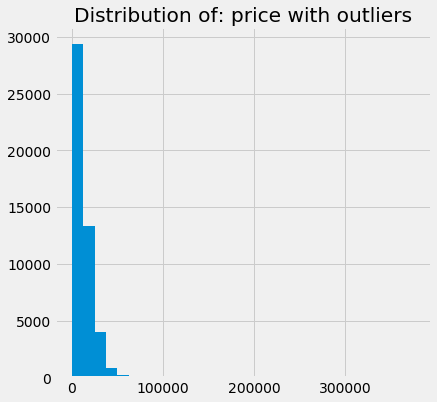

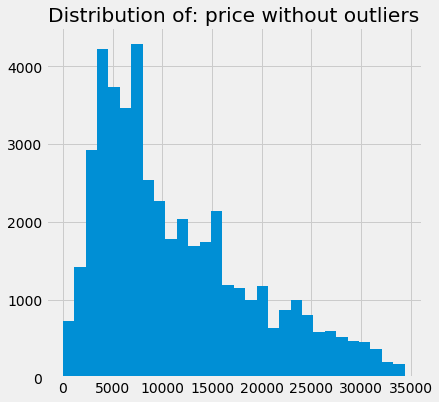

In [49]:
#Price Histogram
plot_histogram_outliers('price',30)
plot_histogram('price',30)

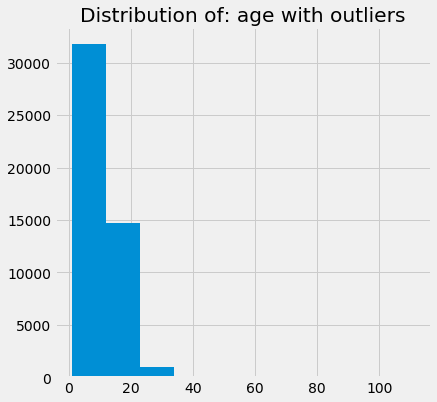

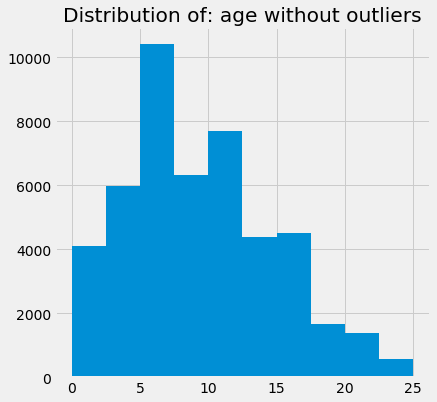

In [50]:
#Age Histogram
plot_histogram_outliers('age')
plot_histogram('age')

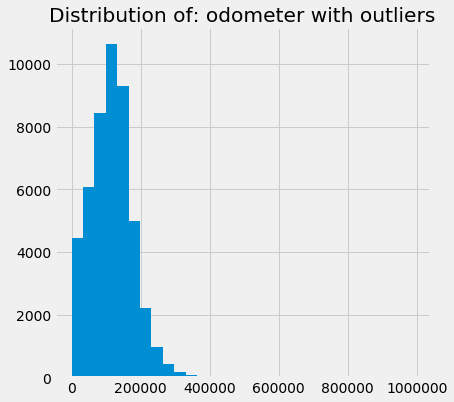

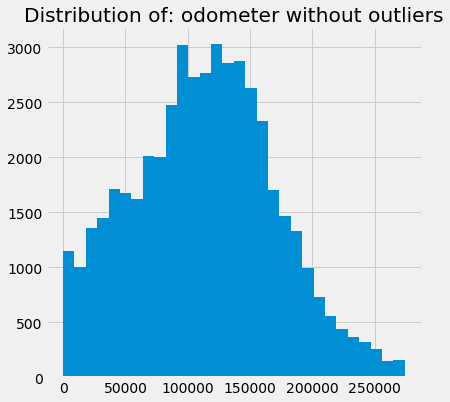

In [51]:
#Mileage
plot_histogram_outliers('odometer',30)
plot_histogram('odometer',minimum = 0, bins = 30)

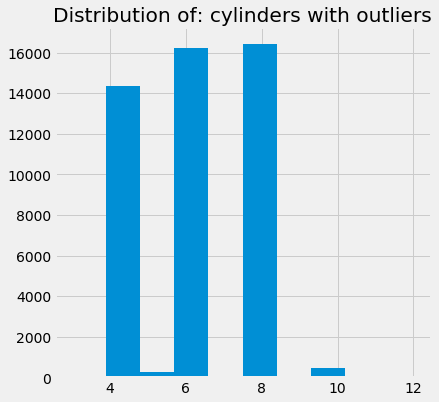

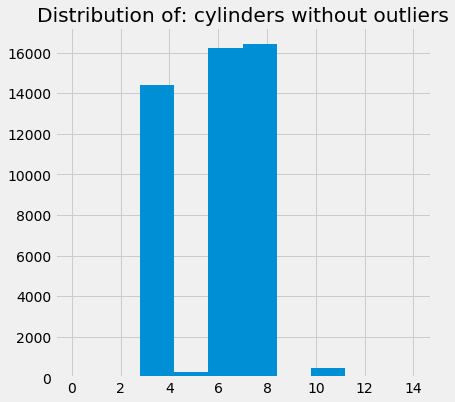

In [52]:
#Number of cylinders
plot_histogram_outliers('cylinders')
plot_histogram('cylinders', minimum = 0)

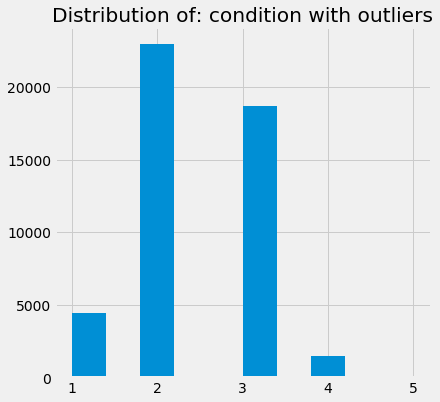

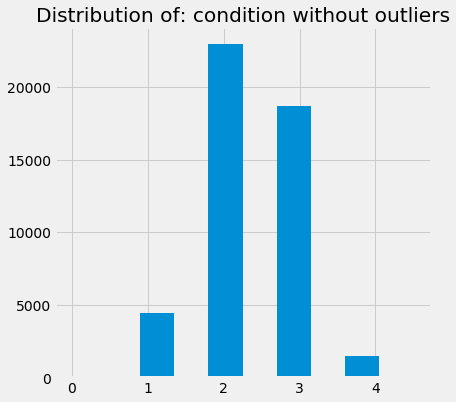

In [53]:
#Condition of cars
plot_histogram_outliers('condition')
plot_histogram('condition', minimum = 0)

Clearly, `price`, `age` and `odometer` have outliers.

## Study and treat outliers

[Given the results above, determine what columns may contain outliers, and create a DataFrame without those outliers. Hint: Outliers can be identified by defining the lower/upper limits for normal range of values.]

We will use 1.5 ± IQR as maximum and minimum permissible values. Anything beyond these values will be considered an outlier.

In [54]:
# Determine the upper and lower limits for outliers
def limits(column):
    iqr = vehicles[column].quantile(0.75) - vehicles[column].quantile(0.25)
    lower_limit = vehicles[column].quantile(0.25) - iqr
    upper_limit = vehicles[column].quantile(0.75) + iqr
    
    return (lower_limit,upper_limit)

In [55]:
price_lower_limit, price_upper_limit = limits('price')
age_lower_limit, age_upper_limit = limits('age')
odometer_lower_limit, odometer_upper_limit = limits('odometer')

In [56]:
# Store data without outliers in a separate DataFrame
good_vehicles = vehicles.query('@price_lower_limit<price<@price_upper_limit')
good_vehicles = good_vehicles.query('@age_lower_limit<age<@age_upper_limit')
good_vehicles = good_vehicles.query('@odometer_lower_limit<odometer<@odometer_upper_limit')
good_vehicles.describe()

,price,condition,cylinders,odometer,days_listed,age,mileage_per_year,day_of_week,month,year
count,41120.000000,41048.000000,41120.000000,41120.000000,41120.000000,41120.000000,41120.000000,41120.000000,41120.00000,41120.000000
mean,11017.065698,2.356120,5.966537,113716.811211,39.555277,9.051946,14553.096605,3.005107,6.64465,2018.304791
std,6892.831186,0.680503,1.648640,51367.422692,28.217834,4.672241,7617.217711,1.997036,3.47049,0.460324
min,11.000000,1.000000,3.000000,1.000000,0.000000,1.000000,0.050000,0.000000,1.00000,2018.000000
25%,5500.000000,2.000000,4.000000,77994.000000,19.000000,5.000000,10117.012500,1.000000,3.00000,2018.000000
50%,9000.000000,2.000000,6.000000,115550.500000,33.000000,8.000000,13236.700000,3.000000,7.00000,2018.000000
75%,15500.000000,3.000000,8.000000,150000.000000,53.000000,12.000000,17350.488095,5.000000,10.00000,2019.000000
max,28588.000000,5.000000,12.000000,233591.000000,271.000000,20.000000,195700.000000,6.000000,12.00000,2019.000000


## Study core parameters without outliers

In [57]:
def plot_histogram_cleaned(column, bins = 10, minimum = -1, maximum = -1):
    if maximum == -1:
        iqr = (good_vehicles[column].quantile(0.75) - good_vehicles[column].quantile(0.25))
        maximum = good_vehicles[column].quantile(0.75) +  1.5 * iqr
    if minimum == -1 :
        minimum = good_vehicles[column].quantile(0.25) -  1.5 * iqr
    minimum = max(0, minimum)
    good_vehicles.hist(column = column, bins = bins, range = (minimum, maximum), figsize = (6,6))
    title = f'Distribution of: {column} without outliers'
    plt.title(title)
    plt.show

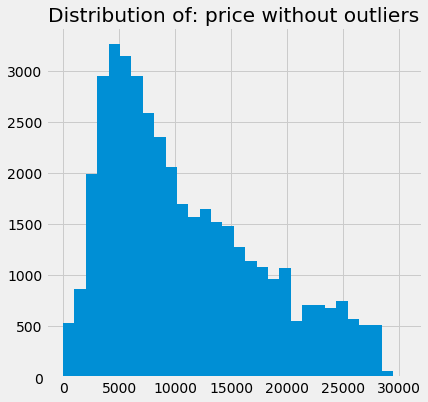

In [58]:
plot_histogram_cleaned('price',30)

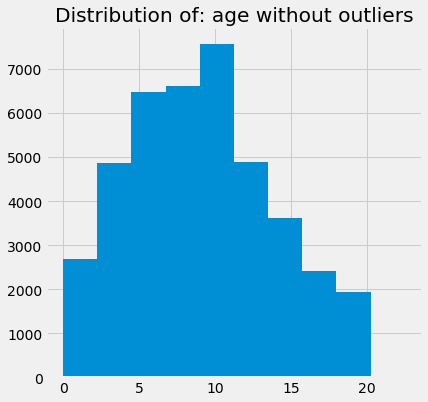

In [59]:
plot_histogram_cleaned('age')

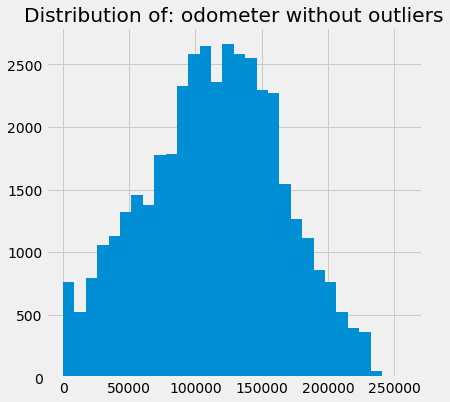

In [60]:
plot_histogram_cleaned('odometer', 30)

## Ads lifetime

In [61]:
good_vehicles['days_listed'].describe()

count    41120.000000
mean        39.555277
std         28.217834
min          0.000000
25%         19.000000
50%         33.000000
75%         53.000000
max        271.000000
Name: days_listed, dtype: float64

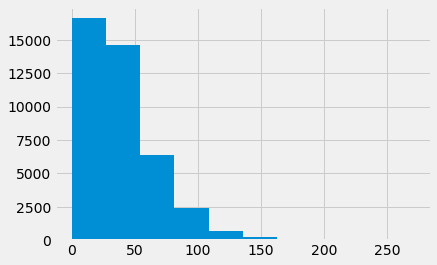

In [62]:
good_vehicles['days_listed'].hist()

In [63]:
good_vehicles.query('days_listed < 1').describe()

,price,condition,cylinders,odometer,days_listed,age,mileage_per_year,day_of_week,month,year
count,41.000000,41.000000,41.000000,41.000000,41.0,41.000000,41.000000,41.000000,41.000000,41.000000
mean,10078.682927,2.439024,6.000000,118400.073171,0.0,10.268293,13252.025636,2.536585,6.731707,2018.268293
std,6363.038682,0.776169,1.612452,58583.580319,0.0,5.286891,6597.407217,2.122470,3.066141,0.448575
min,500.000000,1.000000,4.000000,162.000000,0.0,1.000000,18.000000,0.000000,1.000000,2018.000000
25%,5000.000000,2.000000,4.000000,75465.000000,0.0,6.000000,8578.250000,1.000000,4.000000,2018.000000
50%,9450.000000,2.000000,6.000000,121000.000000,0.0,10.000000,12291.666667,2.000000,7.000000,2018.000000
75%,13995.000000,3.000000,8.000000,152600.000000,0.0,15.000000,16505.000000,4.000000,9.000000,2019.000000
max,26900.000000,4.000000,8.000000,229000.000000,0.0,20.000000,36000.000000,6.000000,12.000000,2019.000000


We will not factor these listing in our analysis as we cannot be certain what transpired or why these ads were taken down. Most likely, these ads were not successful. 

In [64]:
good_vehicles = good_vehicles.query('~days_listed < 1')

In [65]:
good_vehicles.describe()

,price,condition,cylinders,odometer,days_listed,age,mileage_per_year,day_of_week,month,year
count,41120.000000,41048.000000,41120.000000,41120.000000,41120.000000,41120.000000,41120.000000,41120.000000,41120.00000,41120.000000
mean,11017.065698,2.356120,5.966537,113716.811211,39.555277,9.051946,14553.096605,3.005107,6.64465,2018.304791
std,6892.831186,0.680503,1.648640,51367.422692,28.217834,4.672241,7617.217711,1.997036,3.47049,0.460324
min,11.000000,1.000000,3.000000,1.000000,0.000000,1.000000,0.050000,0.000000,1.00000,2018.000000
25%,5500.000000,2.000000,4.000000,77994.000000,19.000000,5.000000,10117.012500,1.000000,3.00000,2018.000000
50%,9000.000000,2.000000,6.000000,115550.500000,33.000000,8.000000,13236.700000,3.000000,7.00000,2018.000000
75%,15500.000000,3.000000,8.000000,150000.000000,53.000000,12.000000,17350.488095,5.000000,10.00000,2019.000000
max,28588.000000,5.000000,12.000000,233591.000000,271.000000,20.000000,195700.000000,6.000000,12.00000,2019.000000


In [66]:
good_vehicles.query('days_listed > 150').describe()

,price,condition,cylinders,odometer,days_listed,age,mileage_per_year,day_of_week,month,year
count,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000
mean,10177.916667,2.348958,5.916667,112911.002604,174.979167,9.031250,14021.571230,2.786458,6.406250,2018.343750
std,6429.197828,0.714911,1.619040,52498.773961,24.849064,4.421398,7283.525040,1.987190,3.555331,0.476201
min,200.000000,1.000000,4.000000,103.000000,151.000000,1.000000,7.923077,0.000000,1.000000,2018.000000
25%,5500.000000,2.000000,4.000000,79766.500000,158.000000,6.000000,9818.750000,1.000000,3.000000,2018.000000
50%,8397.000000,2.000000,6.000000,116174.000000,165.000000,9.000000,13136.107143,3.000000,6.000000,2018.000000
75%,13312.500000,3.000000,8.000000,150400.000000,183.250000,12.000000,16448.292208,4.250000,10.000000,2019.000000
max,27500.000000,4.000000,10.000000,221054.000000,271.000000,20.000000,50149.000000,6.000000,12.000000,2019.000000


It makes sense to drop ads beyond 150 days as it is likely that they were added and forgotten and left up until they were removed. 

In [67]:
good_vehicles = good_vehicles.query('days_listed < 150')

## Average price per each type of vehicle

In [68]:
good_vehicles_stat = good_vehicles.pivot_table(index = 'type', values = ['days_listed','price'], 
                                               aggfunc = {'days_listed':['count','mean'],'price': 'mean'})
good_vehicles_stat.columns = ['ad_count','mean_days_listed','mean_price']
good_vehicles_stat.reset_index(inplace = True)
good_vehicles_stat.sort_values(by='mean_price')

,type,ad_count,mean_days_listed,mean_price
0,bus,7.0,39.857143,5767.857143
3,hatchback,915.0,40.226230,7005.673770
8,sedan,10839.0,38.776548,7201.525141
4,mini-van,1029.0,38.893100,8135.013605
11,van,518.0,38.710425,8665.229730
12,wagon,1323.0,39.309146,9136.981104
6,other,191.0,37.753927,9929.573298
9,suv,10184.0,39.314022,10499.160890
1,convertible,268.0,37.268657,13294.794776
2,coupe,1727.0,38.016213,14204.940938


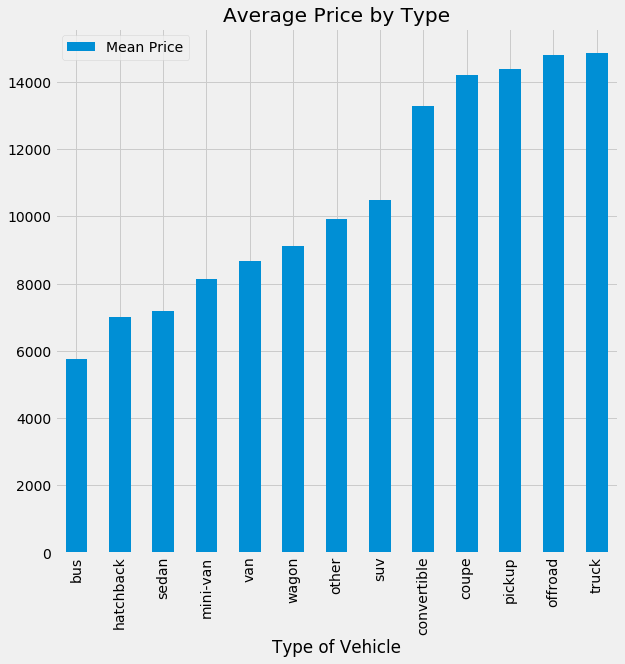

In [69]:
good_vehicles_stat.sort_values(by='mean_price').plot(kind='bar', x= 'type', y = 'mean_price', figsize = (9,9) )
plt.title('Average Price by Type')
plt.xlabel('Type of Vehicle')
#plt.ylabel('Price')
plt.legend().get_texts()[0].set_text('Mean Price')
plt.show()

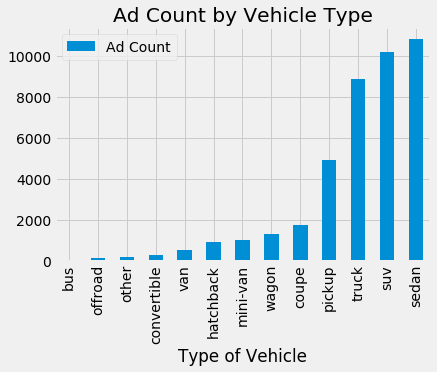

In [70]:
good_vehicles_stat.sort_values(by = 'ad_count').plot(kind = 'bar', x = 'type', y = 'ad_count')
plt.title('Ad Count by Vehicle Type')
plt.xlabel('Type of Vehicle')
#plt.ylabel('Ad Count')
plt.legend().get_texts()[0].set_text('Ad Count')
plt.show()

The most common types of ads are for *sedan* and *suv* type of vehicles. 

## Price factors

In [71]:
good_vehicles.corr(min_periods = 50)['price']

price               1.000000
condition          -0.176670
cylinders           0.351759
odometer           -0.472268
is_4wd              0.349174
days_listed        -0.003048
age                -0.556843
mileage_per_year    0.197710
day_of_week        -0.003121
month              -0.003564
year                0.000753
Name: price, dtype: float64

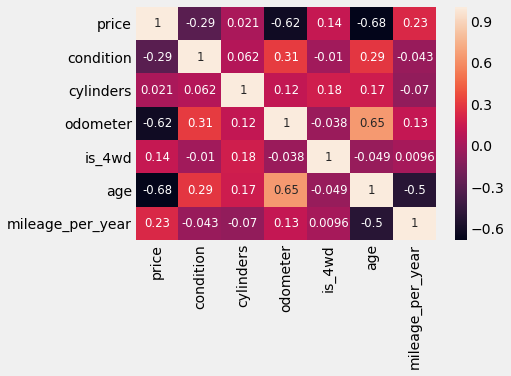

In [101]:
sns.heatmap(sedan[['price','condition','cylinders','odometer','is_4wd','age','mileage_per_year']].corr(),
            annot=True, annot_kws = {'fontsize':'small'})

plt.show()

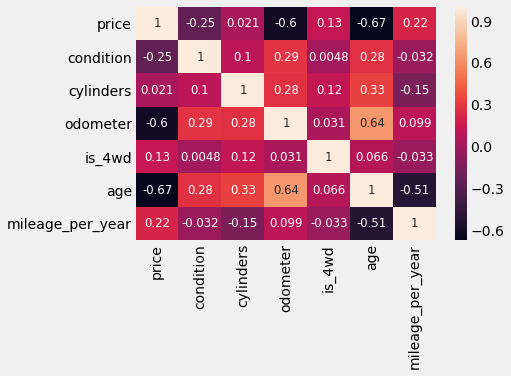

In [102]:
sns.heatmap(suv[['price','condition','cylinders','odometer','is_4wd','age','mileage_per_year']].corr(),
            annot=True, annot_kws = {'fontsize':'small'})

plt.show()

Price correlates linearly to:
1. `age`
2. `odometer`
3. `condition`
4. `cylinders`

In the case both SUVs and sedans. 

Number of cylinders has a markedly stronger effect on SUVs than sedans.

In [78]:
good_vehicles['paint_color'].value_counts()

white      7559
unknown    7370
black      6067
silver     5332
grey       4206
blue       3655
red        3440
green      1002
custom      929
brown       925
yellow      189
orange      178
purple       70
Name: paint_color, dtype: int64

In [79]:
good_vehicles['transmission'].value_counts()

automatic    37514
manual        1946
other         1462
Name: transmission, dtype: int64

In [80]:
def plot_boxplot(df, by):
    df.sort_values(by = 'price').boxplot(column = 'price' , by = by, rot = 60, figsize = (9,9))

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


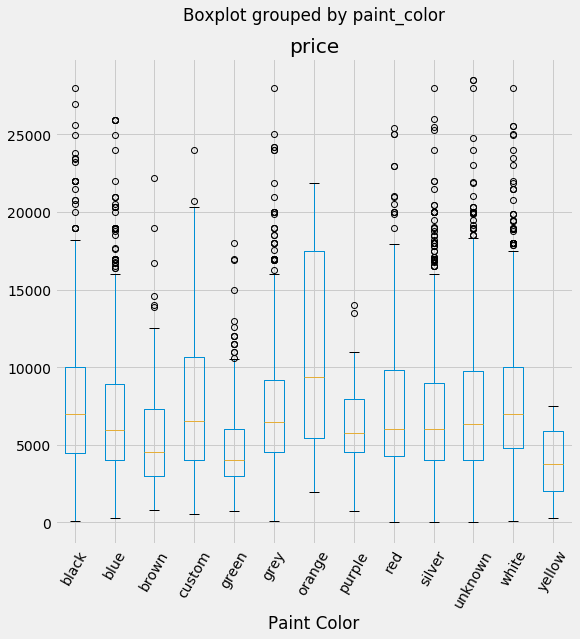

In [103]:
plot_boxplot(sedan,'paint_color')
plt.xlabel('Paint Color')
plt.show()

**Observations**:

1. The highest median prices are commanded by sedans that are orange in color. 
2. We see some outliers. This is expected and the possible reasons are:
    1. The car model is higher spec or customised.
    2. The car is new.
    3. The transmission is automatic which leads to higher price. 
    
A quick peek at the data below confirms points 2 and 3.

In [104]:
sedan.query('price > 16000 and paint_color == "blue"')

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed,age,mileage_per_year,day_of_week,month,year
1691,18998.0,2017-01-01,nissan maxima,2.0,6.0,gas,33124.0,automatic,sedan,blue,False,2018-07-22,24,2,16562.000000,6,7,2018
3387,18998.0,2017-01-01,nissan maxima,2.0,6.0,gas,33124.0,automatic,sedan,blue,False,2018-09-09,11,2,16562.000000,6,9,2018
3848,18998.0,2017-01-01,nissan maxima,2.0,6.0,gas,43200.0,automatic,sedan,blue,False,2019-04-09,83,3,14400.000000,1,4,2019
6249,16995.0,2018-01-01,toyota camry,3.0,4.0,gas,43127.0,automatic,sedan,blue,False,2019-03-26,48,2,21563.500000,1,3,2019
7017,18998.0,2017-01-01,nissan maxima,2.0,6.0,gas,33124.0,automatic,sedan,blue,False,2018-06-18,9,2,16562.000000,0,6,2018
8997,18950.0,2019-01-01,toyota corolla,2.0,4.0,gas,14964.0,automatic,sedan,blue,False,2019-04-02,36,1,14964.000000,1,4,2019
9095,18900.0,2018-01-01,chevrolet impala,2.0,6.0,gas,12940.0,automatic,sedan,blue,False,2018-05-14,9,1,12940.000000,0,5,2018
9424,16990.0,2017-01-01,volkswagen passat,2.0,4.0,gas,31755.0,automatic,sedan,blue,False,2018-08-01,32,2,15877.500000,2,8,2018
10056,21995.0,2018-01-01,chevrolet impala,2.0,6.0,gas,17787.0,automatic,sedan,blue,False,2018-11-20,65,1,17787.000000,1,11,2018
13423,16695.0,2017-01-01,toyota camry,2.0,4.0,gas,27000.0,automatic,sedan,blue,False,2018-12-24,81,2,13500.000000,0,12,2018


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


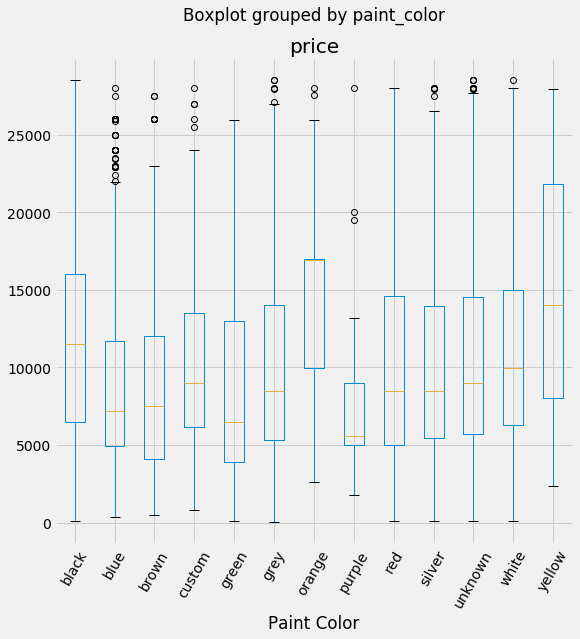

In [105]:
plot_boxplot(suv,'paint_color')
plt.xlabel('Paint Color')
plt.show()

**Some observations**:
1. Orange has the highest median, much higher than most other colors. 
2. Blue and Green colors have a few outliers
3. Yellow cars are likely to be more expensive than others

In [84]:
#What explains the high median in orange vehicles? - let's look at the dataset as a whole.
orange_stats = good_vehicles.query('paint_color == "orange"').pivot_table(index = 'model', values = 'price', 
                                                           aggfunc = ['count','median']).sort_values(by = ('count','price'), ascending = False)
orange_stats.reset_index()['model'].nunique()

40

In [85]:
good_vehicles.describe()

,price,condition,cylinders,odometer,days_listed,age,mileage_per_year,day_of_week,month,year
count,40922.000000,40850.000000,40922.000000,40922.000000,40922.000000,40922.000000,40922.000000,40922.000000,40922.000000,40922.000000
mean,11021.420373,2.356206,5.966815,113720.436746,38.903695,9.052295,14555.213870,3.006134,6.645863,2018.304604
std,6894.335528,0.680311,1.648885,51364.494965,26.626204,4.673620,7618.531014,1.997087,3.470268,0.460245
min,11.000000,1.000000,3.000000,1.000000,0.000000,1.000000,0.050000,0.000000,1.000000,2018.000000
25%,5500.000000,2.000000,4.000000,77994.000000,19.000000,5.000000,10117.236765,1.000000,3.000000,2018.000000
50%,9000.000000,2.000000,6.000000,115537.000000,33.000000,8.000000,13236.700000,3.000000,7.000000,2018.000000
75%,15548.000000,3.000000,8.000000,150000.000000,53.000000,12.000000,17352.428571,5.000000,10.000000,2019.000000
max,28588.000000,5.000000,12.000000,233591.000000,149.000000,20.000000,195700.000000,6.000000,12.000000,2019.000000


In [86]:
good_vehicles.query('paint_color == "orange"').describe()

,price,condition,cylinders,odometer,days_listed,age,mileage_per_year,day_of_week,month,year
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13705.443820,2.292135,6.191011,106568.780899,38.106742,9.707865,13527.750128,3.016854,6.724719,2018.308989
std,6938.363002,0.605105,1.475804,50016.336920,28.611263,4.989712,12782.159045,1.929476,3.499404,0.463380
min,400.000000,1.000000,4.000000,71.000000,3.000000,1.000000,17.750000,0.000000,1.000000,2018.000000
25%,8499.000000,2.000000,6.000000,71198.000000,17.000000,5.250000,8221.802198,1.250000,3.250000,2018.000000
50%,14995.000000,2.000000,6.000000,97346.000000,32.000000,9.000000,11565.416667,3.000000,7.000000,2018.000000
75%,17986.750000,3.000000,8.000000,139955.750000,52.250000,14.000000,15598.800000,5.000000,9.750000,2019.000000
max,27995.000000,4.000000,10.000000,211960.000000,146.000000,20.000000,157000.000000,6.000000,12.000000,2019.000000


40 different models(out of 100), therefore there is definitely a trend. The mean and median are higher, which clearly means this color is considered to be a more "premium" color. 

In [87]:
#What explains the high median in yellow vehicles?
yellow_stats = good_vehicles.query('paint_color == "yellow"').pivot_table(index = 'model', values = 'price', 
                                                           aggfunc = ['count','median']).sort_values(by = ('count','price'), ascending = False)
yellow_stats.reset_index()['model'].nunique()

37

In [88]:
good_vehicles.query('paint_color == "yellow"').describe()

,price,condition,cylinders,odometer,days_listed,age,mileage_per_year,day_of_week,month,year
count,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000
mean,13885.174603,2.497354,6.984127,108858.248677,39.952381,8.682540,17086.174375,3.005291,6.772487,2018.285714
std,7800.989873,0.665441,1.982574,55186.726623,26.831683,5.597754,11862.491060,2.001322,3.445022,0.452954
min,299.000000,1.000000,4.000000,180.000000,1.000000,1.000000,16.363636,0.000000,1.000000,2018.000000
25%,6295.000000,2.000000,6.000000,64880.000000,18.000000,3.000000,9090.909091,1.000000,4.000000,2018.000000
50%,14995.000000,3.000000,6.000000,122637.000000,35.000000,9.000000,13158.681818,3.000000,7.000000,2018.000000
75%,17990.000000,3.000000,8.000000,139220.000000,53.000000,13.000000,21741.400000,5.000000,10.000000,2019.000000
max,28000.000000,4.000000,10.000000,231089.000000,128.000000,20.000000,40991.333333,6.000000,12.000000,2019.000000


Only 37 models out of 100 offer yellow color. The median of yellow color is higher than the median of the dataset as a whole, indiciating once again that this color is rarer and more likely to be used in premium car models with higher price

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


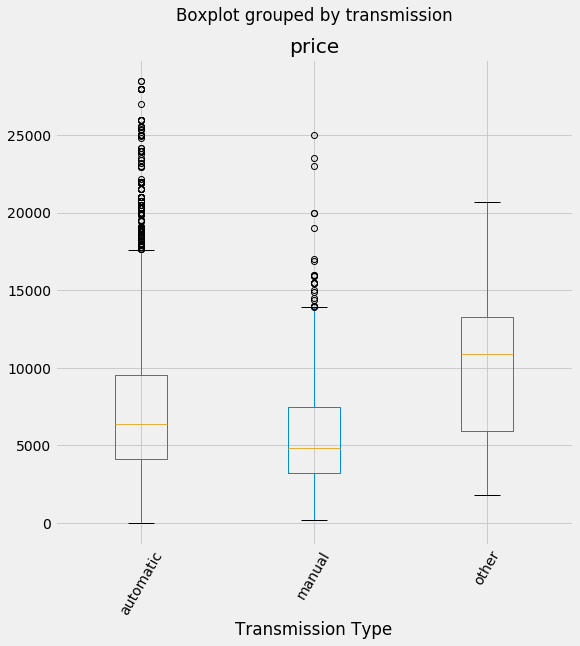

In [106]:
plot_boxplot(sedan,'transmission')
plt.xlabel('Transmission Type')
plt.show()

1. Automatic Transmissions tend to have a higher median price than manual transmissions. 
2. "Other" transmissions command the highest medians but have significant outliers. Let's look closely down the line.

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


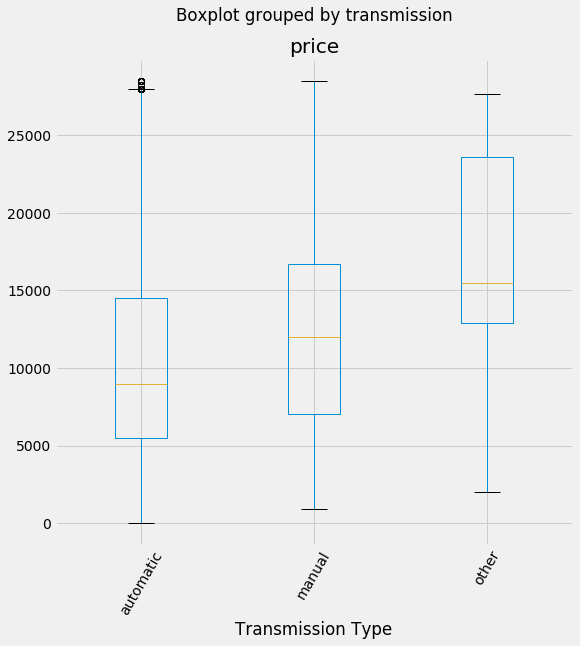

In [107]:
plot_boxplot(suv,'transmission')
plt.xlabel('Transmission Type')
plt.show()

The trend appears reversed for SUVs. Manual SUVs are likely to command higher prices than Automatic SUVs

A possible explanation is that only higher end SUVs. This makes these SUVs more likely to be expensive. A look at specific models below shows that Manual SUVs are less common. The most common models are Jeep Wrangler and Jeep Wrangler Unlimited which are expensive vehicles in general.

In [108]:
suv.query('transmission == "manual"')['model'].value_counts()

jeep wrangler              192
jeep wrangler unlimited     42
subaru forester             34
kia soul                    12
jeep liberty                10
toyota rav4                  8
ford escape                  8
subaru outback               7
hyundai santa fe             6
honda pilot                  6
honda cr-v                   6
bmw x5                       5
toyota 4runner               5
ford explorer                4
jeep grand cherokee          3
kia sorento                  3
chevrolet traverse           2
chevrolet tahoe              2
toyota highlander            2
ford edge                    2
gmc acadia                   2
ford expedition              2
subaru impreza               2
buick enclave                2
chevrolet suburban           1
cadillac escalade            1
ram 3500                     1
chevrolet equinox            1
Name: model, dtype: int64

In [109]:
suv.query('transmission == "automatic"')['model'].value_counts()

ford escape                 681
ford explorer               620
jeep grand cherokee         578
honda cr-v                  498
chevrolet equinox           489
                           ... 
toyota tundra                 1
honda civic lx                1
dodge dakota                  1
ford focus                    1
chevrolet silverado 1500      1
Name: model, Length: 63, dtype: int64

In [110]:
sedan.query('transmission == "other"')['model'].value_counts()

dodge charger               21
nissan altima               17
toyota corolla              12
honda accord                 9
nissan sentra                7
toyota camry                 6
hyundai sonata               5
volkswagen jetta             5
ford focus                   3
hyundai elantra              3
chevrolet cruze              3
subaru impreza               1
chevrolet silverado 1500     1
honda civic lx               1
toyota camry le              1
ford fusion                  1
honda civic                  1
ford taurus                  1
nissan maxima                1
Name: model, dtype: int64

In [111]:
suv.query('transmission == "other"')['model'].value_counts()

jeep wrangler                 65
jeep grand cherokee           11
toyota rav4                    7
kia soul                       5
gmc yukon                      4
nissan rogue                   4
ford expedition                3
subaru forester                2
jeep liberty                   2
chevrolet trailblazer          2
ford escape                    2
hyundai santa fe               2
honda cr-v                     2
ford explorer                  2
jeep cherokee                  1
subaru outback                 1
chevrolet traverse             1
jeep grand cherokee laredo     1
ford edge                      1
chevrolet tahoe                1
gmc acadia                     1
toyota 4runner                 1
toyota highlander              1
Name: model, dtype: int64

"Other" Transmissions can are likely to include:
1. Dual Clutch Transmissions - these are generally more expensive.
2. Custom Tranmissions - Tranmissions specifically built for a specific purpose(racing,drifting etc.).
3. Off-Road transmissions - Low range gearboxes which are likely to be more expensive.

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


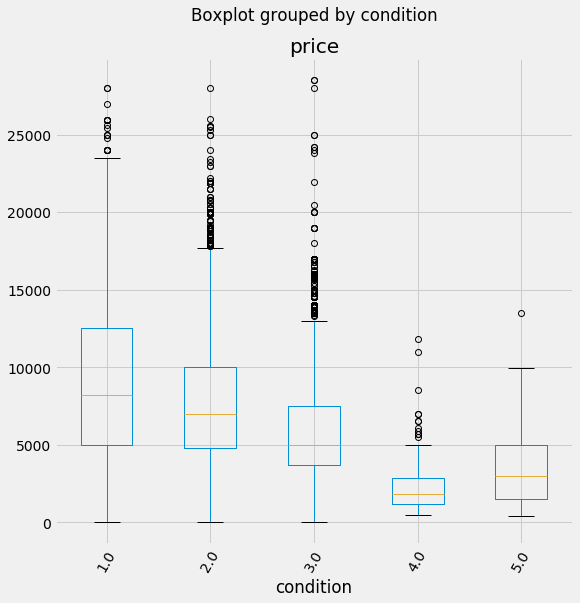

In [112]:
plot_boxplot(sedan, 'condition')

It appears to be better to salvage a sedan than to sell it in a condition marked as fair. 

Outliers are expected as vehicle condition is a subjective variable based on perception that may vary significantly across people.

In [113]:
sedan.query('condition == 4')['age'].median()

14.0

In [114]:
sedan.query('condition == 4')['odometer'].median()

153730.0

In [115]:
sedan.query('condition == 5')['age'].median()

8.0

In [116]:
sedan.query('condition == 5')['odometer'].median()

99752.5

Vehicles marked as "fair" are likely to be older and have more mileage on them. Since these factors influence price more strongly, they likely pull the price lower.

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


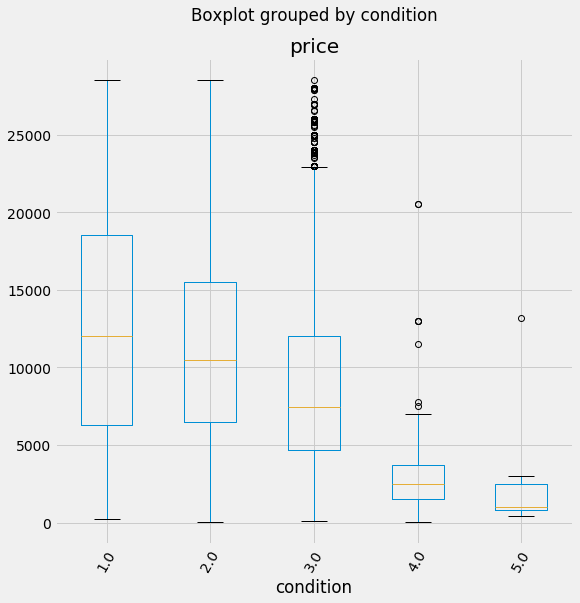

In [117]:
plot_boxplot(suv,'condition')

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


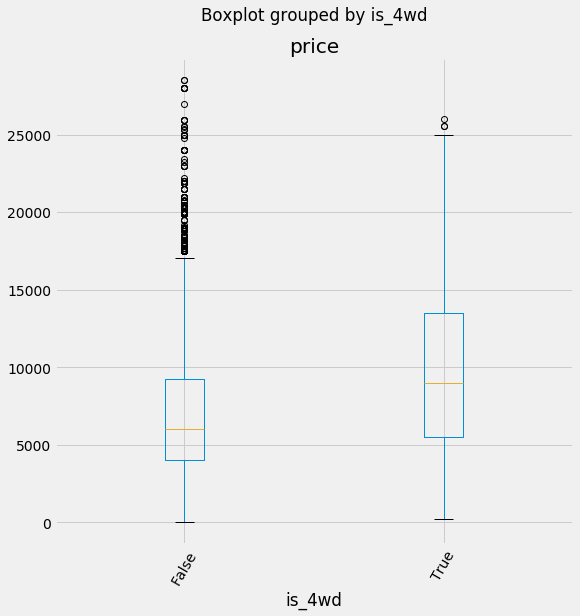

In [118]:
plot_boxplot(sedan,'is_4wd')

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


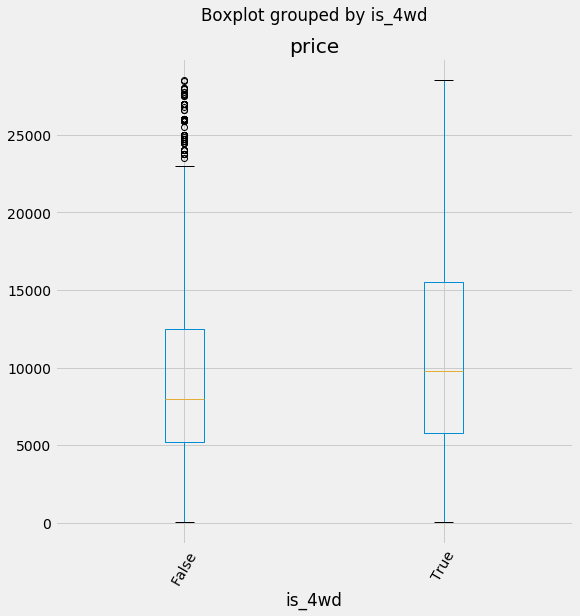

In [119]:
plot_boxplot(suv,'is_4wd')

4 Wheel drive vehicles are likely to be more expensive and that is evidenced in our plots above.

In [120]:
def scatter_plot(df,column):
    df.plot(kind='scatter', x = column, y = 'price', figsize = (6,6))
    
    plt.show()

In [96]:
sedan = good_vehicles.query('type == "sedan"')
sedan.name  = 'Sedan'
suv = good_vehicles.query('type == "suv"')
suv.name = 'SUV'

Plotting for vehicle type: Sedan


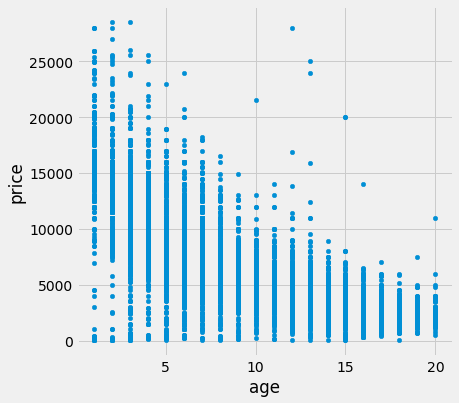

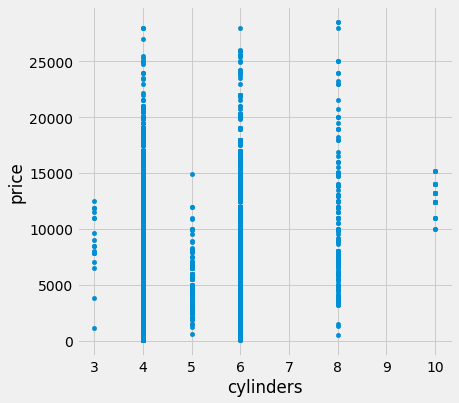

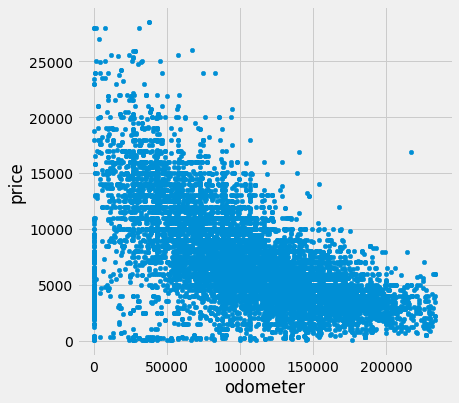

In [99]:
columns = ['age','cylinders','odometer']
print('Plotting for vehicle type:',sedan.name)
for column in columns:
        scatter_plot(sedan,column)

Plotting for vehicle type: SUV


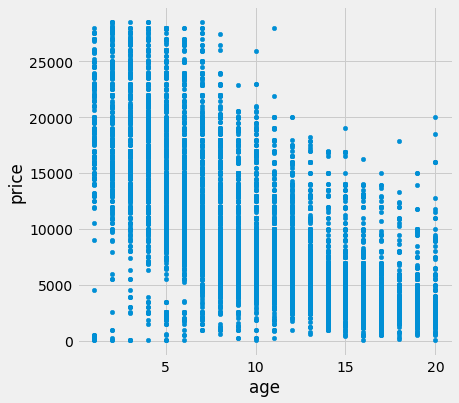

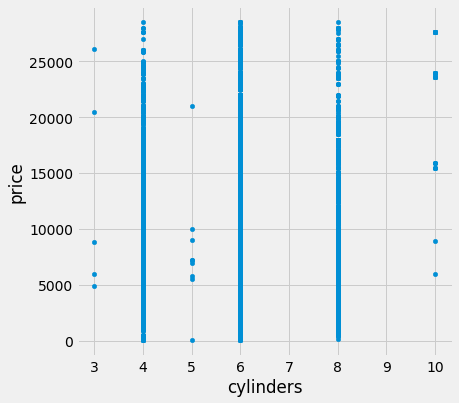

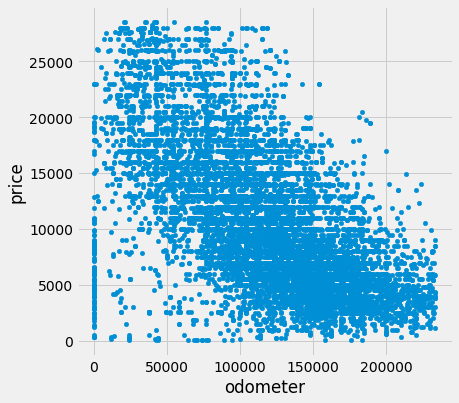

In [100]:
columns = ['age','cylinders','odometer']
print('Plotting for vehicle type:',suv.name)
for column in columns:
        scatter_plot(suv,column)

**Observations**:
1. As age increases, price tends to decrease, with the density of data points increasing towards lower prices as we increase age.
2. In general, cars with higher number of cylinders are likely to have higher prices.
3. With higher odometer readings, price decreases. 

## General conclusion

### The Data:

We had a dataset of car prices with the following fields:

- `price`
- `model_year`
- `model`
- `condition`
- `cylinders`
- `fuel` — gas, diesel, etc.
- `odometer` — the vehicle's mileage when the ad was published
- `transmission`
- `paint_color`
- `is_4wd` — whether the vehicle has 4-wheel drive (Boolean type)
- `date_posted` — the date the ad was published
- `days_listed` — from publication to removal

### The Goal:

Attempting to find factors that influence the price of a vehicle by understanding the distribution of price with categorical and numerical variables.

### Missing Values:

We start by looking at the missing values and filling them up as accurately as possible.

#### `model_year`
We cannot fill these values as these are extremely subjective. We lose about 7% of the data by dropping these unknown values.

#### `odometer`
We fill any values that are marked as NaN or 0 with medians for equivalent `type` and `model_year`. A very small percentage of values are dropped since we are unable to fill them.

#### `cylinders` 
We fill these values with medians(since number of cylinders cannot be fractional)of equivalent `model` of vehicle

#### `paint_color`
We are unable to inferentially fill this value. Since we do not expect this column to play as significant a role as other columns, we marked NaN values as unknown.

### Fixing Data Types

#### `date_posted`
Converted to datetime from object.
#### `is_4wd`
Soldified Boolean values by replacing NaN with 0 and changed type to `bool`

#### Data Enrichment
1. Added `age` (in years) as a column
2. Added `mileage_per_year` column as `odometer` / `age`

### Core Parameters and Outliers:

1. Studied core parameters such as `price`, `cylinders`, `odometer`, `age` and `condition` with outliers by plotting histogram plots

2. Eliminated outliers using Inter-Quartile Ranges for `price`,`odometer` and `age`

3. Comparatively plotted before and after graphs to ensure distribution followed expectations. 

### Ads Lifetime Study:

We observed the lifetime of ads in our dataset. The median lifetime is approximately 33 days.

We also observed ads that were live for 0 days or more than 150 days. Both were dropped as we suspect issues with these ads such as:

1. The ads were place erroneously or had missing information and hence were taken down.
2. The ads did not pass required guidelines so were taken down.
3. The ads were posted and the original poster either forgot about the ad or used a different source, thus leaving the ad up for a long duration.

As the ads made up a very small fraction of our data, we dropped these values.

### Average Price per Type:

We plotted the average price by type of vehicle. Trucks and Offroaders have the highest average prices of all types while busses and hatchbacks have the lowest. Since only 7 busses are present in our data, this value is questionable and not very critical.

### Price Factors

We studied several categorical and numerical price factors including: 
- `age`
- `odometer`
- `paint_color`
- `transmission`
- `cylinders`
- `condition`
- `is_4wd`

#### Age:

The price decreases with age but some outliers can be spotted. These are likely to be vintage cars with collector's value. 

#### Odometer:

We see a definite trend towards decreasing prices as odometer reading (mileage) increases. Once again, some outliers can be explained to be vintage cars with antiquity value.

#### Paint Color:

We are forced to work around significant missing values here. We captured some trends such as *Yellow* and *Orange* colors having generally higher prices. This was explained by hypothesising that these colors are uncommon (~40% models have these) and <1% of cars in our data had one of the two colors. The value may in the uniqueness. 

#### Transmission

Automatic Tranmissions are likely to be priced higher. However, we also discovered that transmission in the "Other" category are likely to be priced the highest (with siginificant outliers). These may be unconventional transmissions such as sport gearboxes, DCTs, low range gearboxes or custom gearboxes. 

#### Cylinders:

More cylinders imply higher price as the vehicle is likely to be larger and have a bigger engine.

#### Condition

Better condition leads to better price, as expected with very few exceptions.

#### 4WD

Vehicles with 4WD are likely to command higher prices.

### Conclusion:

We successfully studied the impact of various factors on the price of a vehicle on a listing website. We eliminated outliers and dealt with missing values. We plotted correlations between price and the various factors. Ultimately, we pointed out the factors that affect pricing along with the mechanism of the relation between the two. 

### Libraries Used:
- *pandas*
- *numpy*
- *matplotlib*
- *seaborn*